# Convert profiles vertical coordinate from Hybrid-Pressure to altitude

In [1]:
%matplotlib inline
# for figures in notebook

# import & initialize epygram
import epygram
epygram.init_env()

import os
INPUTS_DIR = os.path.join(epygram.config.installdir, 'doc_sphinx', 'source', 'gallery', 'inputs')

In [2]:
r = epygram.resources.meta_resource(os.path.join(INPUTS_DIR, 'ICMSHAROM+0022'), 'r', 'CL')  # CL = CombineLevels

In [3]:
# in a "CL" meta-resource, fields are to be grabbed through a GRIB2 nomenclature
t_as_grib2 = dict(discipline=0, parameterCategory=0, parameterNumber=0,  # this is temperature
                  typeOfFirstFixedSurface=119)  # hybrid-pressure levels

In [4]:
t3d = r.readfield(t_as_grib2)

In [5]:
t3d.sp2gp()

In [6]:
# extract profiles
profiles = []
for position in [(6.1,46.2), (6.8,45.8), (6,46.5)]:
    profgeo = t3d.geometry.make_profile_geometry(*position)  # make a V1D geometry at that position
    profiles.append(t3d.extract_subdomain(profgeo))  # extract subdomain corresponding to the geometry of the profile

/usr/lib64/python3.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


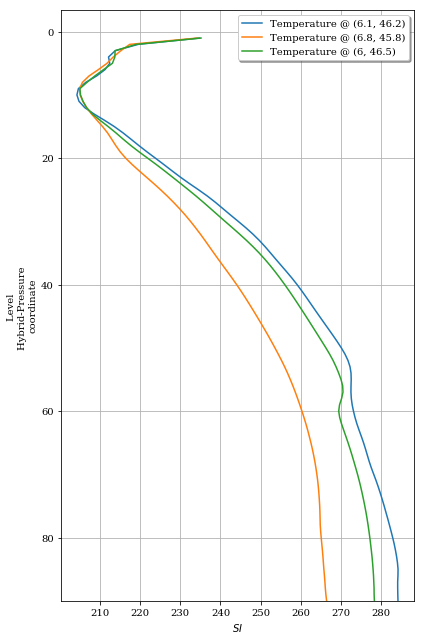

In [7]:
fig = ax = None
for p in profiles:
    fig, ax = p.plotfield(labels='Temperature @ ({}, {})'.format(p.geometry.grid['longitudes'][0],
                                                                 p.geometry.grid['latitudes'][0]),
                          over=(fig, ax))  # superpose profiles

## and now on an Altitude z-axis

In [8]:
# for the conversions, we need R and T profiles, so (at least) q and T
q_as_grib2 = dict(discipline=0, parameterCategory=1, parameterNumber=0,  # this is specific humidity
                  typeOfFirstFixedSurface=119)  # on hybrid-pressure levels
q3d = r.readfield(q_as_grib2)

In [9]:
# but also Surface pressure and geopotential
ps = epygram.formats.resource(r.resource.container.abspath, 'r').readfield('SURFPRESSION')
zs = epygram.formats.resource(r.resource.container.abspath, 'r').readfield('SPECSURFGEOPOTEN')
# Ps is spectral and ln(Ps)
ps.sp2gp()
ps.operation('exp')
zs.sp2gp()

In [10]:
from epygram.geometries.VGeometry import hybridP2altitude
from bronx.meteo.conversion import q2R

for p in profiles:
    q_profile = q3d.extract_subdomain(p.geometry).data  # profile of q at the same place
    # specific humidity (and optionally hydrometeors) to moist air specific constant R
    R_profile = q2R(q_profile)
    t_profile = p.data
    ps_local = ps.getvalue_ll(p.geometry.grid['longitudes'][0],
                              p.geometry.grid['latitudes'][0])
    zs_local = zs.getvalue_ll(p.geometry.grid['longitudes'][0],
                              p.geometry.grid['latitudes'][0])
    # create the Z vertical coordinate
    p.geometry.vcoordinate = hybridP2altitude(p.geometry.vcoordinate,
                                              R_profile,
                                              t_profile,
                                              ps_local,
                                              vertical_mean='geometric',
                                              Phi_surf=zs_local,
                                              Pdep=None)  # we could also provide a (NH) Pressure-departure profile for more accuracy

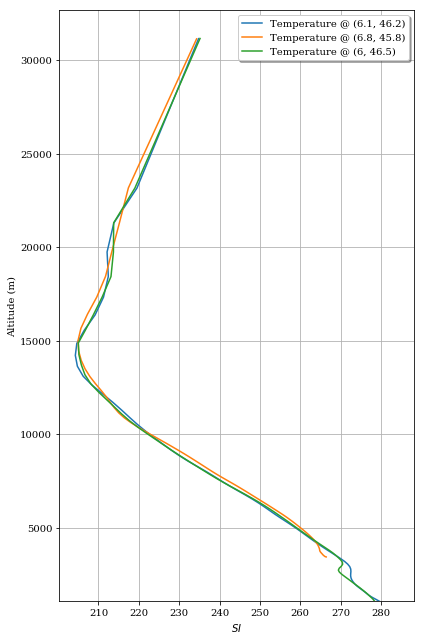

In [11]:
fig = ax = None
for p in profiles:
    fig, ax = p.plotfield(labels='Temperature @ ({}, {})'.format(p.geometry.grid['longitudes'][0],
                                                                 p.geometry.grid['latitudes'][0]),
                          over=(fig, ax))  # superpose profiles